# Coresets with DPPs

In [1]:
import numpy as np
# import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline
%load_ext autoreload 
%autoreload 2
# some highlight keywords by VSCode: TODO, FIXME, BUG, XXX, HACK, NOTE 
# TODO: refactor OPE sample to make one simple OPE sampler and one OPE+uniform sampler
# TODO: sample example
# TODO: message save figure link

## Inspection

### Data generation

drawn lengths are: 1024, 1027, 1023, 1010, 1014, 1019, 

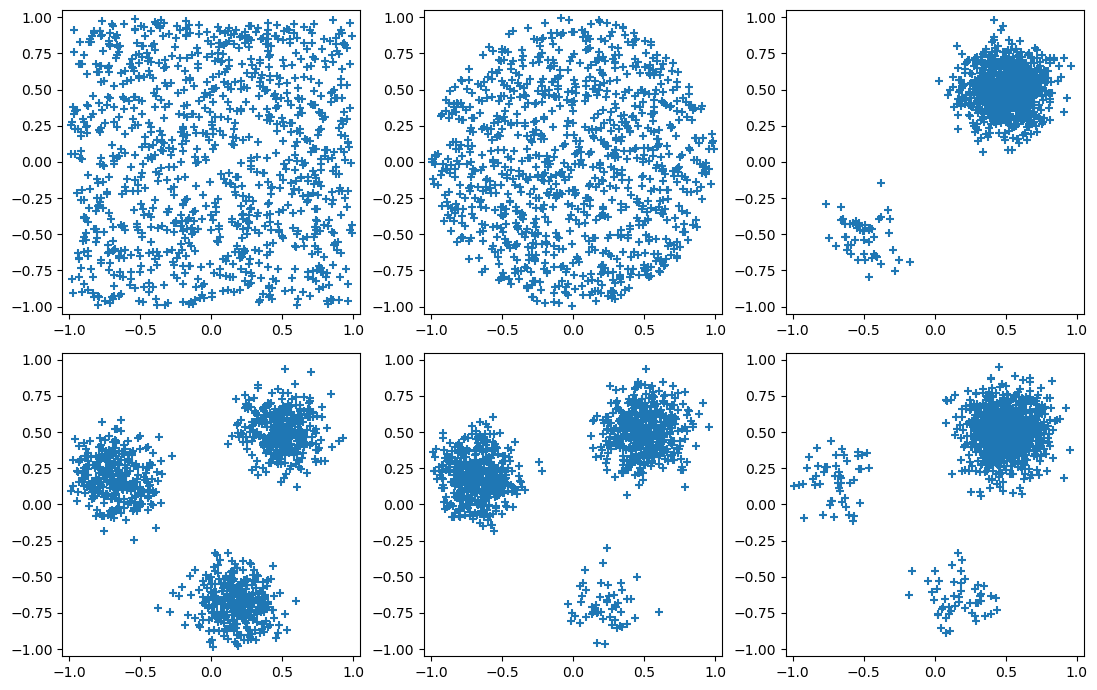

In [2]:
from utils import get_hypercube_data, get_circle_data, get_disk_data, get_corner_data

def draw_data(desired_n, d, k, prop_outliers=5/100, border=0.99):
    # generate data
    # radius_corner = 0.5*2**.5
    X_uniform = get_hypercube_data(desired_n, d, border=border)
    # X_corner = get_corner_data(desired_n, d, k, border=border)
    X_disk = get_disk_data(desired_n, d, radius=1)
    X_kcent_knonout = get_circle_data(desired_n, d, k, border=border)
    X1 = get_circle_data(desired_n*(1-k*prop_outliers), d, k, 2, border=border)
    X2 = get_circle_data(desired_n*k*prop_outliers, d, k, border=border)
    X_kcent_2nonout = np.concatenate((X1, X2))
    X1 = get_circle_data(desired_n*(1-k*prop_outliers), d, k, 1, border=border)
    X2 = get_circle_data(desired_n*k*prop_outliers, d, k, border=border)
    X_kcent_1nonout = np.concatenate((X1, X2))
    X2 = get_circle_data(desired_n*(1-2*prop_outliers), d, 2, 1, border=border)
    X1 = get_circle_data(desired_n*2*prop_outliers, d, 2, border=border)
    X_outlier = np.concatenate((X1, X2))
    # X1 = get_circle_data(desired_n/2, d, 5, border=border)
    # X2 = get_circle_data(desired_n/2, d, 1, radius=0, variance=1/49, border=.99)
    # X_5subbubbles = np.concatenate((X1, X2))
    # X1 = get_circle_data(desired_n*5/100, d, 2, radius=radius_corner, variance=1/49, border=.99)
    # X2 = get_circle_data(desired_n*95/100, d, 1, radius=0, variance=1/49, border=.99)
    # X_2vs1_1 = np.concatenate((X1, X2))
    # X1 = get_circle_data(desired_n/2, d, 2, radius=radius_corner, variance=1/49, border=.99)
    # X2 = get_circle_data(desired_n/2, d, 1, radius=0, variance=1/49, border=.99)
    # X_2vs1_2 = np.concatenate((X1, X2))
    # X1 = get_circle_data(desired_n*95/100, d, 2, radius=radius_corner, variance=1/49, border=.99)
    # X2 = get_circle_data(desired_n*5/100, d, 1, radius=0, variance=1/49, border=.99)
    # X_2vs1_3 = np.concatenate((X1, X2))
    # Xs = [X_uniform, X_disk, X_corner, X_3centers, X_5subbubbles, X_outlier, X_2vs1_1, X_2vs1_2, X_2vs1_3]
    Xs = [X_uniform, X_disk, X_outlier, X_kcent_knonout, X_kcent_2nonout, X_kcent_1nonout]
    print("drawn lengths are:", end=" ")
    for dataset in Xs:
        print(len(dataset), end=", ")
    return Xs

# plot
desired_n, d, k = 1024, 2, 3
Xs = draw_data(desired_n, d, k)
xylim = 1.05
plt.figure(figsize=(11,7)) # (12,5.5)
for i_plot, X_plot in enumerate(Xs):
    plt.subplot(2,int(np.ceil(len(Xs)/2)),i_plot+1), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X_plot[:,0], X_plot[:,1], marker="+")
plt.tight_layout(), plt.show();

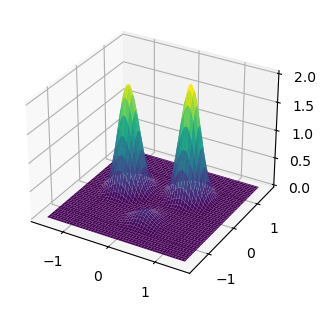

In [3]:
from sklearn.neighbors import KernelDensity
from interfaces import plot3d_func

# compute and plot KDE
kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(Xs[4])
gamma_tilde_pdf = lambda X: np.exp(kde.score_samples(X))
plt.figure(figsize=(8,4))
ax = plt.subplot(121, projection="3d")
plot3d_func(ax, gamma_tilde_pdf, 100)
plt.show();

### Sensitivity

In [4]:
from utils import get_true_sensit

# draw data with less datapoints because of latency 
desired_n, d, k = 200, 2, 3
Xs = draw_data(desired_n, d, k)
Xs = np.array(Xs, dtype=object)[[0,2,3,4]]

# compute and plot sensitivity
sensits = []
for i_plot, X_plot in enumerate(Xs):
    sensits.append(get_true_sensit(X_plot, k))

drawn lengths are: 200, 191, 200, 200, 197, 200, 

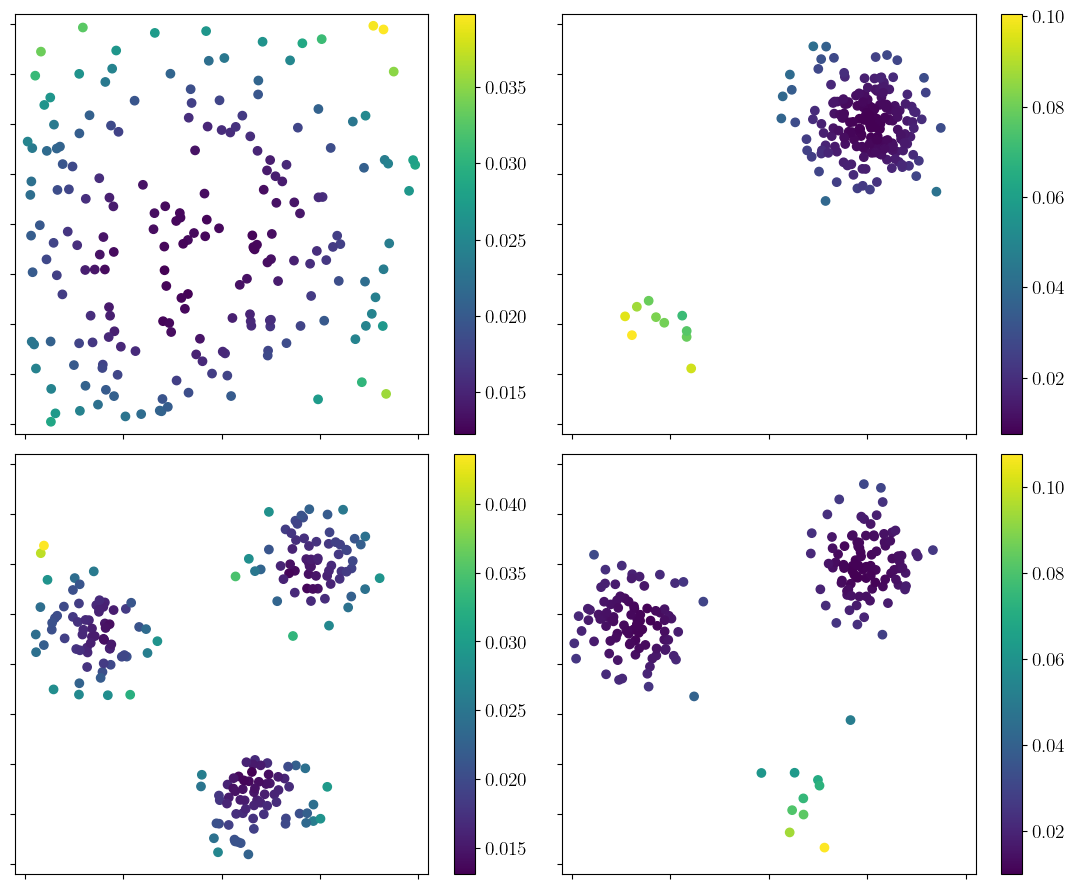

interactive(children=(FloatSlider(value=11.0, continuous_update=False, description='fig_width', max=20.0, min=…

interactive(children=(Text(value='./figs/', description='fig_directory'), Text(value='datasets_sensitivity_exa…

In [6]:
def my_plot():
    for i_plot, X_plot in enumerate(Xs):
        sensit = sensits[i_plot]
        plt.subplot(2,round(len(Xs)/2),i_plot+1), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
        plt.scatter(X_plot[:,0], X_plot[:,1], c=sensit), plt.colorbar();
        plt.gca().set_xticklabels([]), plt.gca().set_yticklabels([]) 
from interfaces import save_plots_interface
save_plots_interface(my_plot, fig_size=(11,9), plot_on_call=True, use_TeX=True, font_size=14, fig_name="datasets_sensitivity_example")

### Gaussian k-DPP weights check

empirically yields m=5.000, which should be close to m=5


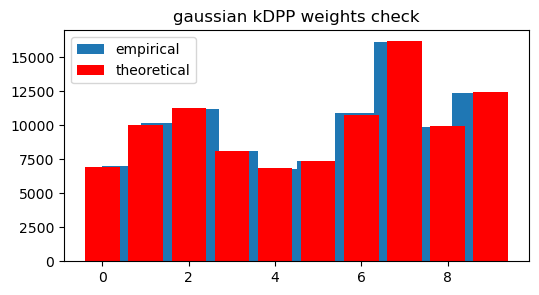

In [5]:
from samplers import gaussian_kernel, get_kDPP_weights, draw_gaussian_kDPP
 
d, n, m, k = 2, 10, 5, 3
X = get_hypercube_data(n, d, border=.99)
n_samples = 20000
bandwidth = 1

likelihood = gaussian_kernel(X, bandwidth)
weights = get_kDPP_weights(likelihood, m)
samples, _ = draw_gaussian_kDPP(X, m, n_samples, bandwidth)
samples = samples.flatten()
print(f"empirically yields m={(1/(n*weights)).sum():.3f}, which should be close to {m=}")
plt.figure(figsize=(6,3))
plt.hist(samples, density=False, label="empirical")
plt.bar(np.arange(len(X)), n_samples/(n*weights), color='r', label="theoretical")
plt.title("gaussian kDPP weights check"), plt.legend();

### Sampling example

obtained n=300
/!\ OPE sampling and gamma_X is None
it will be KDE estimated, inducing n^2 complexity


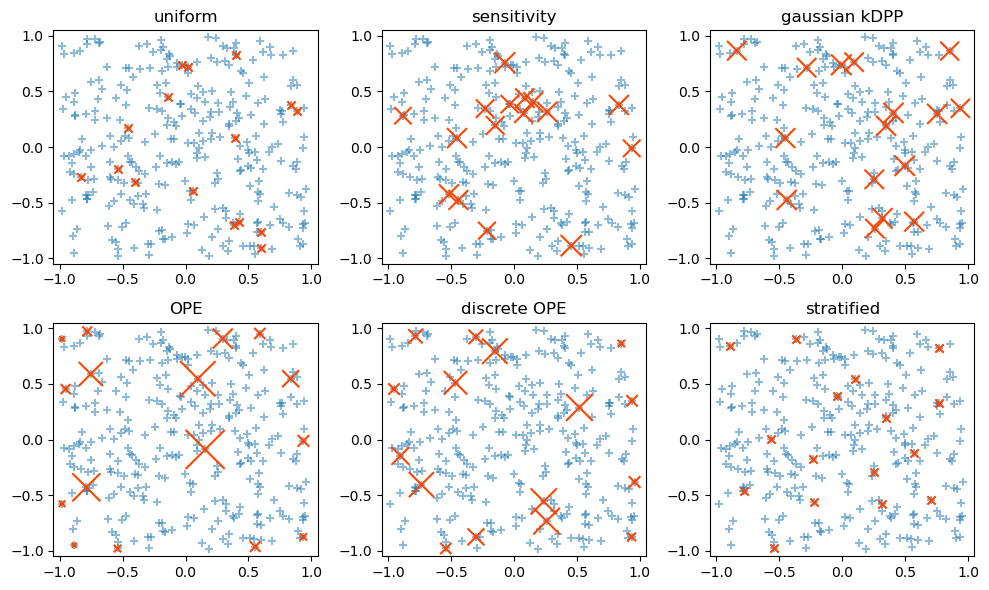

In [10]:
from samplers import draw_uniform, draw_sensitivity, draw_stratified, draw_gaussian_kDPP, draw_OPE, draw_discrete_OPE

# generate data
d, desired_n, m, k = 2, 300, 16, 5
n_samples = 1
radius_corner = 0.5*2**.5
X = get_hypercube_data(desired_n, d, border=.99)
n = len(X)
print(f"obtained {n=}")

# sample
samples_weights_list = []
samples_weights_list.append( draw_uniform(X, m, n_samples) )
samples_weights_list.append( draw_sensitivity(X, m, n_samples, k, delta=.1) )
samples_weights_list.append( draw_gaussian_kDPP(X, m, n_samples, bandwidth=.1) )
samples_weights_list.append( draw_OPE(X, m, n_samples, prop_uniform=0) )
samples_weights_list.append( draw_discrete_OPE(X, m, n_samples) )
samples_weights_list.append( draw_stratified(X, m, n_samples) )

# plot
titles = ["uniform","sensitivity","gaussian kDPP","OPE","discrete OPE","stratified"]
plt.figure(figsize=(10,6))
for k, (samples, weights) in enumerate(samples_weights_list):
    X_samples = X[samples]
    xylim = 1.05
    plt.subplot(2,len(titles)//2+len(titles)%2,k+1), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X[:,0], X[:,1], marker='+', alpha=.5)
    for i_sample in range(n_samples):
        weight = None
        if weights is not None: weight= 200*m*weights[i_sample]
        plt.scatter(X_samples[i_sample,:,0], X_samples[i_sample,:,1], marker="x", s=weight, color="orangered")
    plt.title(titles[k])
    # plt.gca().set_xticklabels([]), plt.gca().set_yticklabels([])
plt.tight_layout(), 
plt.savefig("./figs/samplers_example.svg")
plt.savefig("./figs/samplers_example.pdf")
plt.show();

### Variance and relative error rate

## Statistics

In [13]:
# from utils import get_hypercube_data, get_corner_data, get_circle_data
from samplers import draw_uniform, draw_sensitivity, draw_stratified, draw_gaussian_kDPP, draw_OPE, draw_discrete_OPE
from utils import loss, relative_error
from interfaces import save_variables_interface
from sklearn.neighbors import KernelDensity

# data parameters
d, desired_n, k = 2, 1024, 3    # 2, 1024, 3
# draw data
Xs = draw_data(desired_n, d, k)
X_names = ["X_uniform", "X_disk", "X_outlier", "X_kcent_knonout", "X_kcent_2nonout", "X_kcent_1nonout"]

drawn lengths are: 1024, 1028, 1024, 1008, 1016, 1021, 

In [23]:
i_dataset = 0 # choose the dataset index. 0 for uniform dataset.
X, X_name = Xs[i_dataset], X_names[i_dataset]
print(f"experimenting on {X_name} dataset")
n = len(X)
print(f"obtained {n=}")

# repetitions parameters
n_queries, n_rep = 100, 200 # 50, 500
ms = np.arange(1,14, dtype=int)**2 # (1,14)
print(f"m list={ms}")
bandwidths = [.01, .05, .10, .20, .30] # for uniform dataset
prop_uniforms = [1., 0.5, 0.25, 0.12, 0.] # for uniform dataset

# init queries
queries = X[np.random.choice(n, (n_queries,k), replace=False)] # np.zeros((1,1,X.shape[-1]))

# init OPE sampler by pre-computing KDE on data
kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(X)
kde_distr = np.exp(kde.score_samples(X))
# just draw from OPE to test and show in scatter plot
m = ms[-1]
OPE_samples, OPE_weights = draw_OPE(X, m, 1, gamma_X=kde_distr, prop_uniform=0)

SE_means, SE_stds, relerrs = [], [], []
for m in ms:
    print(f"{m=}")
    # sample
    samples_weights_list = []

    # draw from samplers, experimenting for any datasets
    samples_weights_list.append( draw_uniform(X, m, n_rep) )
    samples_weights_list.append( draw_sensitivity(X, m, n_rep, k, delta=.1) )
    samples_weights_list.append( draw_gaussian_kDPP(X, m, n_rep, bandwidth=.1) )
    samples_weights_list.append( draw_OPE(X, m, n_rep, gamma_X=kde_distr, prop_uniform=0) )
    samples_weights_list.append( draw_discrete_OPE(X, m, n_rep) )

    # draw from samplers, experimenting on uniform dataset only
    if i_dataset==0:
        print("drawing from samplers conveived for experimenting on uniform dataset only")
        samples_weights_list.append( draw_stratified(X, m, n_rep) )
        for bandwidth in bandwidths:
            samples_weights_list.append( draw_gaussian_kDPP(X, m, n_rep, bandwidth=bandwidth) )
        for prop_uniform in prop_uniforms:
            samples_weights_list.append( draw_OPE(X, m, n_rep, gamma_X=kde_distr, prop_uniform=prop_uniform) )
        
    # compute metrics for all samplers
    loss_samples = []
    for samples, weights in samples_weights_list:

        for query in queries:
            # evaluate the population loss and the sample loss
            loss_X = loss(X, query) 
            loss_samples = loss(X, query, samples, weights)

            # compute metrics
            SEs = (loss_samples - loss_X)**2
            SE_means.append(SEs.mean(-1))
            SE_stds.append(SEs.std(-1))
            relerrs.append(relative_error(loss_samples, loss_X))

# aggregate metrics
n_ms, n_samplers = len(ms), len(samples_weights_list)
relerrs_sup = np.reshape(relerrs, (n_ms, n_samplers, n_queries, n_rep)).max(2) # max on queries
SE_means, SE_stds = np.reshape(SE_means, (n_ms, n_samplers, n_queries)), np.reshape(SE_stds, (n_ms, n_samplers, n_queries))
SE_means_argmax = SE_means.argmax(2) # argmax on queries
arr1, arr2 = np.ogrid[:n_ms,:n_samplers]
SE_means_sup = SE_means[arr1, arr2, SE_means_argmax]
SE_stds_sup = SE_stds[arr1, arr2, SE_means_argmax]

file_name = f"{X_name}_n{n}_m{m}_{k}means{n_queries}_{n_rep}rep"
save_variables_interface("relerrs_sup, SE_means_sup, SE_stds_sup", 
                    output_name=file_name, 
                    save_on_call=True)

experimenting on X_uniform dataset
obtained n=1024
m list=[  1   4   9  16  25  36  49  64  81 100 121 144 169]


In [24]:
file_name = "X_uniform_n1024_m169_3means100_200rep"
loading_temp = np.load("./npys/"+file_name+".npy", allow_pickle=True).item()
relerrs_sup, SE_means_sup, SE_stds_sup, = loading_temp.values()

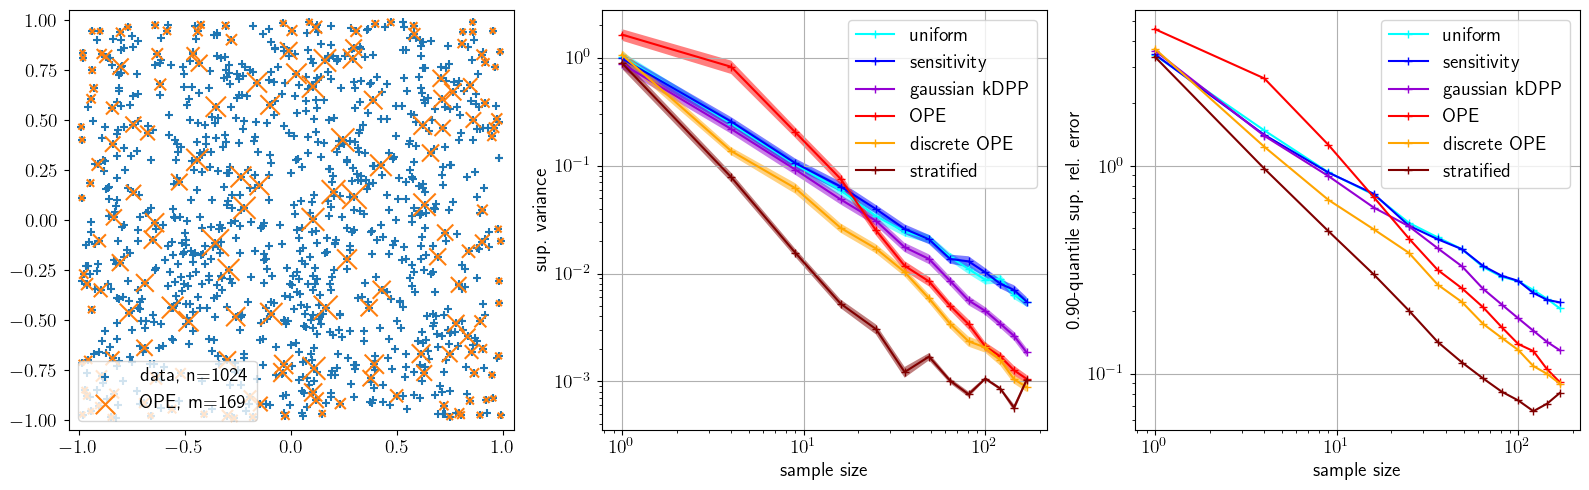

interactive(children=(FloatSlider(value=16.0, continuous_update=False, description='fig_width', max=20.0, min=…

interactive(children=(Text(value='./figs/', description='fig_directory'), Text(value='X_uniform_n1024_m169_3me…

In [28]:
def my_plot():
    n_stds = 1*n_rep**(-.5) # number of standard deviations to plot
    xylim = 1.05

    plt.subplot(131), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X[:,0], X[:,1], marker="+", label=f"data, {n=}")
    X_samples, X_weights = X[OPE_samples[0]], 100*ms[-1]*OPE_weights[0]
    plt.scatter(X_samples[:,0],X_samples[:,1], marker="x", label=f"OPE, m={ms[-1]}", s=X_weights)
    plt.legend()

    plt.subplot(132)
    # draw from samplers, experimenting for any datasets
    legends = ["uniform","sensitivity","gaussian kDPP","OPE","discrete OPE"]
    selector = range(len(legends))

    # draw from samplers, experimenting on uniform dataset only
    if i_dataset==0:
        legends += ["stratified"]
        legends += [f"gkDPP, h={bandwidth:.2f}" for bandwidth in bandwidths]
        legends += [f"prop unif={prop_uniform:.2f}" for prop_uniform in prop_uniforms]
        selector_uniform_samplers = [0,1,2,3,4,5]
        selector_uniform_gkdpp = [0,6,7,8,9,10]
        selector_uniform_propunif = [11,12,13,14,15]
        ##### choose one selector #####
        selector = selector_uniform_samplers
        # selector = selector_uniform_gkdpp
        # selector = selector_uniform_propunif
        legends = np.array(legends)[selector]
    
    colors = ["cyan","blue","darkviolet","red","orange","maroon"]
    # cmap = plt.get_cmap('viridis') # viridis, magma
    # colors = cmap(np.linspace(0,.9,len(legends)))[::-1]
    plt.gca().set_prop_cycle(color=colors)
    plt.plot(ms, SE_means_sup[:,selector], label=legends, marker="+")
    for k in selector:
        plt.fill_between(ms, SE_means_sup[:,k]+n_stds*SE_stds_sup[:,k], SE_means_sup[:,k]-n_stds*SE_stds_sup[:,k], alpha=.5)
    plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel("sup. variance"), 
    plt.legend(), plt.grid()

    plt.subplot(133)
    delta_quant = .1 # .1, .01
    relerr_quant = np.quantile(relerrs_sup, 1-delta_quant, axis=-1)
    plt.gca().set_prop_cycle(color=colors)
    plt.plot(ms, relerr_quant[:,selector], label=legends, marker="+")
    plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel(f"{1-delta_quant:.2f}-quantile sup. rel. error")
    plt.legend(), plt.grid(),

from interfaces import save_plots_interface
save_plots_interface(my_plot, fig_size=(16,5), plot_on_call=True, use_TeX=True, font_size=14, fig_name=file_name)

### Power regression

In [ ]:
from sklearn.linear_model import LinearRegression

def power_regression(x, y):
    logx, logy = np.log(x)[:,None], np.log(y)
    reg = LinearRegression().fit(logx, logy)
    power, factor = reg.coef_, np.exp(reg.intercept_)
    R_squared = reg.score(logx, logy)
    return power, factor, R_squared

In [ ]:
def my_plot():
    n_stds = 1*n_rep**(-.5) # number of standard deviations to plot
    xylim = 1.05

    plt.subplot(111)
    delta_quant = .1 # .1, .01
    relerr_quant = np.quantile(relerrs_sup, 1-delta_quant, axis=-1)
    plt.gca().set_prop_cycle(color=colors)
    for k in selector:
        power, factor, R_squared = power_regression(ms, relerr_quant[:,k])
        plt.plot(ms, np.exp(power*ms+factor))
        legends[k] += [f", slope$\simeq${power}"]

    plt.plot(ms, relerr_quant[:,selector], label=legends, marker="+")
    plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel(f"{1-delta_quant:.2f}-quantile sup. rel. error")
    plt.legend(), plt.grid(),

from interfaces import save_plots_interface
save_plots_interface(my_plot, fig_size=(16,5), plot_on_call=True, use_TeX=True, font_size=14, fig_name=file_name)

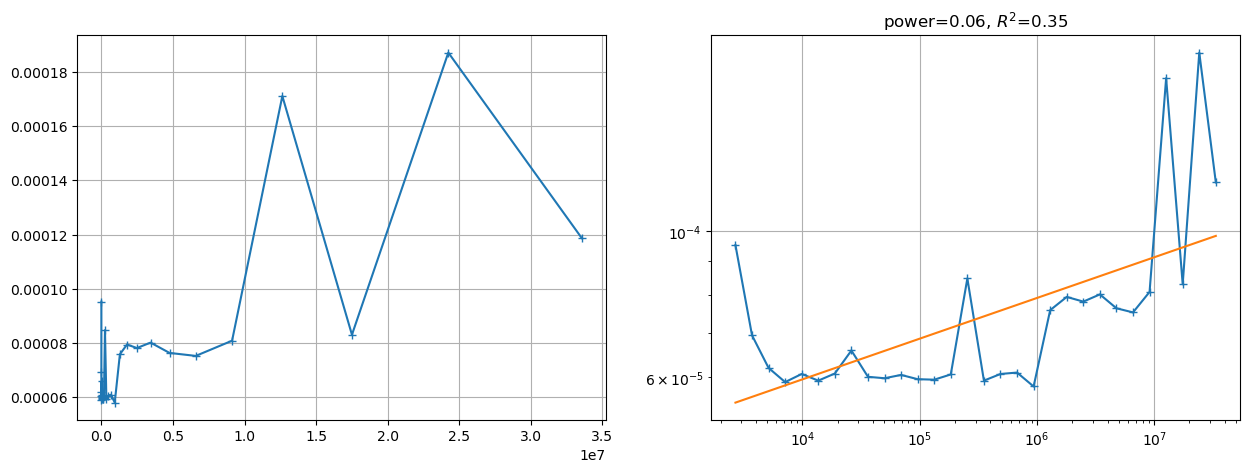

In [27]:
from sklearn.linear_model import LinearRegression

def power_regression(x, y):
    plt.subplot(121)
    plt.plot(x, y, marker="+"), plt.grid()
    logx, logy = np.log(x)[:,None], np.log(y)
    reg = LinearRegression().fit(logx, logy)
    power, factor = reg.coef_, np.exp(reg.intercept_)
    R_squared = reg.score(logx, logy)
    
    plt.subplot(122)
    plt.plot(x, y, marker="+")
    plt.plot(x, np.exp(reg.predict(logx)))
    plt.xscale('log'), plt.yscale('log')
    plt.title(f"power={power[0]:.2f}, $R^2$={R_squared:.2f}"), plt.grid();
    return reg

k_start = 20
plt.figure(figsize=(15,5))
fitted_reg = power_regression(n_list[k_start:], elapsed_times[k_start:])

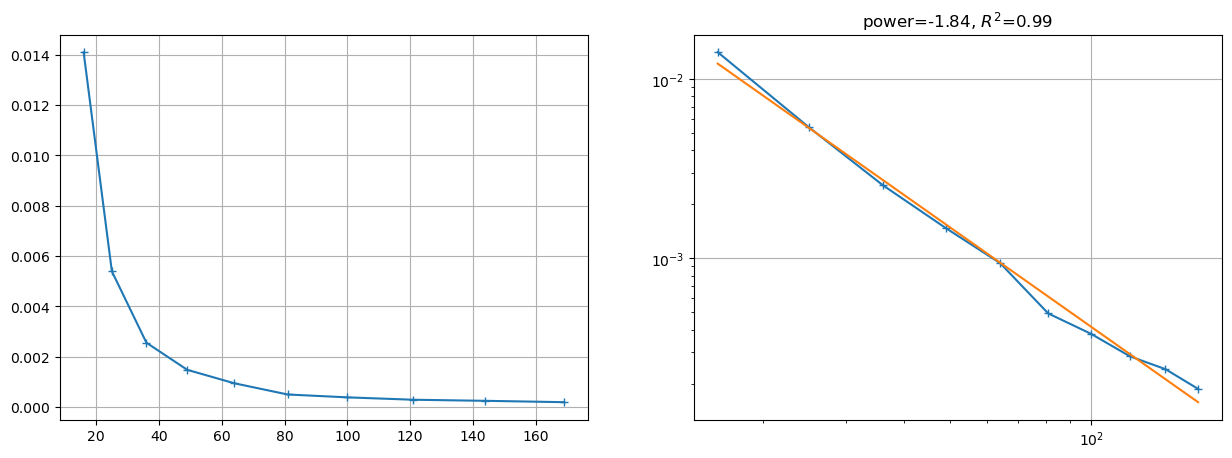

In [44]:
k_start, k_end = 3, None
plt.figure(figsize=(15,5))
fitted_reg = power_regression(ms[k_start:k_end], SE_means[:,2][k_start:k_end])

### Benchmark DPPy sample_exact

In [26]:
from timeit import default_timer as timer
elapsed_times = []
n_list = []
d, n, nb_rep = 2, 2000, 10
ns = np.round(np.logspace(2, 25, num=50, base=2)).astype(int) # 20
# ns = np.arange(1, 30)**4
print(ns)
ab_coeff = 0
ab_coeff_array = np.zeros((d,2)) + ab_coeff
for n in ns:
    print(f"n={n}")
    start_time = timer()
    for rep in range(nb_rep):
        # X = get_hypercube_data(n, d)
        # obtain P which decompose continuous DPP K = PP^T
        # dpp = MultivariateJacobiOPE(m, ab_coeff_array)
        # polynom_X = dpp.eval_multiD_polynomials(X)
        # eig_vals, eig_vecs, weights = draw_OPE(X, int(m), gamma_X=.25)
        # OPE_samples = get_DPP_samples(eig_vals[:m], eig_vecs[:,:m], n_samples=2)
        # gamma_tilde = stats.gaussian_kde(X.T)
        # gamma_X = gamma_tilde.pdf(X.T)
        truc= np.round(n*np.random.rand(nb_rep))
    n_list.append(n)
    elapsed_times.append(timer() - start_time)

[       4        6        8       11       15       20       28       39
       54       75      104      143      198      275      380      527
      729     1010     1398     1935     2680     3710     5136     7111
     9846    13632    18874    26131    36179    50090    69351    96018
   132939   184057   254831   352820   488487   676320   936380  1296439
  1794947  2485144  3440736  4763774  6595549  9131681 12643011 17504524
 24235395 33554432]
n=4
n=6
n=8
n=11
n=15
n=20
n=28
n=39
n=54
n=75
n=104
n=143
n=198
n=275
n=380
n=527
n=729
n=1010
n=1398
n=1935
n=2680
n=3710
n=5136
n=7111
n=9846
n=13632
n=18874
n=26131
n=36179
n=50090
n=69351
n=96018
n=132939
n=184057
n=254831
n=352820
n=488487
n=676320
n=936380
n=1296439
n=1794947
n=2485144
n=3440736
n=4763774
n=6595549
n=9131681
n=12643011
n=17504524
n=24235395
n=33554432


In [25]:
np.random.choice(n, nb_rep), np.random.rand(n, nb_rep).shape

(array([20451574,  6466630, 30246717, 25200919,  1867114, 11104117,
         2257348, 16958323,  4892921, 30294148]),
 (33554432, 10))